<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Все необходимые импорты выношу в отдельную ячейку.

In [22]:
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
!pip3 install catboost
from catboost import CatBoostClassifier

Смотрю общую информацию.

In [23]:
data = pd.read_csv('Churn_Modelling.csv')
display(data.info())
display(data.head())
display(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


(10000, 14)

Имеются пропуски в данных.

Немного поработаю над внешним видом таблицы, а именно переименую колонки, хочется, чтобы в некоторых были разделители в названиях для большей наглядности. Также я удалю `RowNumber`, `Surname` на мой взгляд для обучения модели они не нужны - не несут полезной информации.

In [24]:
data = data.drop(['RowNumber', 'Surname'],axis=1)
data.columns = ['Customer_Id', 'Credit_Score', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'Num_Of_Products', 'Has_Cr_Card',
       'Is_Active_Member', 'Estimated_Salary', 'Exited']
data.head()

,Customer_Id,Credit_Score,Geography,Gender,Age,Tenure,Balance,Num_Of_Products,Has_Cr_Card,Is_Active_Member,Estimated_Salary,Exited
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Посмотрим на данные с пропусками в колонке `Tenure`.

In [25]:
data_tenure = data.query('Tenure.isna()')
display(data_tenure)

,Customer_Id,Credit_Score,Geography,Gender,Age,Tenure,Balance,Num_Of_Products,Has_Cr_Card,Is_Active_Member,Estimated_Salary,Exited


Данные говорят о том, что клиенты имеют кредитный рейтинг, пользуются продуктами банка, некоторые из них имеют кредитную карту карту. Предлагаю заполнить пропуски медианой.

In [26]:
median_tenure = data['Tenure'].median()
display(median_tenure)

5.0

In [27]:
data = data.fillna(median_tenure)
display(data.head())
display(data.info())

,Customer_Id,Credit_Score,Geography,Gender,Age,Tenure,Balance,Num_Of_Products,Has_Cr_Card,Is_Active_Member,Estimated_Salary,Exited
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Customer_Id       10000 non-null  int64  
 1   Credit_Score      10000 non-null  int64  
 2   Geography         10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Tenure            10000 non-null  int64  
 6   Balance           10000 non-null  float64
 7   Num_Of_Products   10000 non-null  int64  
 8   Has_Cr_Card       10000 non-null  int64  
 9   Is_Active_Member  10000 non-null  int64  
 10  Estimated_Salary  10000 non-null  float64
 11  Exited            10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


None

In [28]:
data.duplicated().sum()

0

Дубликатов и пропусков нет.

## Исследование задачи

На данном этапе обучаю модель, не изучая вопрос дисбаланса классов.
Возьму модель случайного леса и логистической регрессии.

Прежде чем начать обучение, необходимо преобразовать категориальные признаки в численные. В этом мне поможет техника прямого кодирования(OHE). Для прямого кодирования использую функцию pd.get_dummies() с аргументом drop_first=True.

In [29]:
data = pd.get_dummies(data, drop_first=True)
display(data)

,Customer_Id,Credit_Score,Age,Tenure,Balance,Num_Of_Products,Has_Cr_Card,Is_Active_Member,Estimated_Salary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,15634602,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,15647311,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,15619304,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,15701354,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,15737888,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,39,5,0.00,2,1,0,96270.64,0,0,0,1
9996,15569892,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1
9997,15584532,709,36,7,0.00,1,0,1,42085.58,1,0,0,0
9998,15682355,772,42,3,75075.31,2,1,0,92888.52,1,1,0,1


Разделяю данные. Переменные `feature_train`, `feature_test`, `feature_valid` содержат признаки для обучения тестирования и валидации соответственно. Переменные `target_train`, `target_test`, `target_valid` содержат целевые признаки.

In [30]:
feature = data.drop(['Exited'], axis=1)
target = data['Exited']

feature_train, feature_test, target_train, target_test = train_test_split(
    feature, target, test_size=0.25, random_state=12345)

feature_train, feature_valid, target_train, target_valid = train_test_split(
    feature_train, target_train, test_size=0.25, random_state=12345)

In [31]:
display(feature_train.shape)
display(feature_valid.shape)
display(feature_test.shape)

(5625, 12)

(1875, 12)

(2500, 12)

Логистическая регрессия.

In [32]:
model = LogisticRegression(random_state=12345, solver='liblinear',penalty='l1')
model.fit(feature_train, target_train)
predicted_valid = model.predict(feature_valid)
print("f1-score:", f1_score(target_valid, predicted_valid))
print("roc-auc-score:" , roc_auc_score(target_valid, model.predict_proba(feature_valid)[:, 1]))

f1-score: 0.3104125736738703
roc-auc-score: 0.7910403098046119


Случайный лес.

In [33]:
model = RandomForestClassifier(random_state=12345, n_estimators=26, max_depth=10) 
model.fit(feature_train, target_train)
predicted_valid = model.predict(feature_valid)
print("f1-score:", f1_score(target_valid, predicted_valid))
print("roc-auc-score:" , roc_auc_score(target_valid, model.predict_proba(feature_valid)[:, 1]))

f1-score: 0.5597269624573379
roc-auc-score: 0.8555175145220912


Улучшим метрики, работая с дисбалансом.

## Борьба с дисбалансом

0    7963
1    2037
Name: Exited, dtype: int64


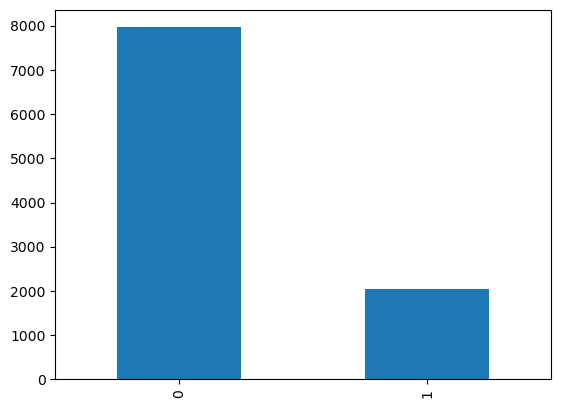

In [34]:
class_target = data['Exited'].value_counts()
class_target.plot(kind='bar')
print(class_target)

Класс 0 явно превосхоит класс 1, разница примерно в 4 раза.

Если указать аргумент `class_weight='balanced'` можно наблюдать прирост качества в обоих метриках.

Логистическая регрессия.

In [35]:
model = LogisticRegression(random_state=12345, solver='liblinear',penalty='l1', class_weight='balanced')
model.fit(feature_train, target_train)
predicted_valid = model.predict(feature_valid)
print("f1-score:", f1_score(target_valid, predicted_valid))
print("roc-auc-score:", roc_auc_score(target_valid, predicted_valid))

f1-score: 0.5127238454288408
roc-auc-score: 0.7211054391832423


/Users/anechakhina/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Случайный лес.

In [36]:
model = RandomForestClassifier(random_state=12345, n_estimators=26, max_depth=10, class_weight='balanced') 
model.fit(feature_train, target_train)
predicted_valid = model.predict(feature_valid)
print("f1-score:", f1_score(target_valid, predicted_valid))
print("roc-auc-score:", roc_auc_score(target_valid, predicted_valid))

f1-score: 0.6093959731543624
roc-auc-score: 0.7525303643724696


В случае логистической регрессии прирост качества наблюдается значительный, но модель случайного леса все же превосходит ее по качеству.

Увеличение выборки. Upsampling.

Необходимо: 

- Разделить обучающую выборку на отрицательные и положительные объекты;
- Скопировать несколько раз положительные объекты;
- С учётом полученных данных создать новую обучающую выборку;
- Перемешать данные: идущие друг за другом одинаковые вопросы не помогут обучению.

Все вышеперечисленные шаги выполняет функция `upsample`.

In [37]:
def upsample(feature, target, repeat):
    feature_zeros = feature[target == 0]
    feature_ones = feature[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    feature_upsample = pd.concat([feature_zeros] + [feature_ones] * repeat)
    target_upsample  = pd.concat([target_zeros] + [target_ones] * repeat)
    feature_upsample, target_upsample = shuffle(feature_upsample, target_upsample, random_state = 12345)
    
    return feature_upsample, target_upsample

feature_upsample, target_upsample = upsample(feature_train , target_train, 5)

#print(feature_upsample.shape)
#print(target_upsample.shape)

Обучим модели на расширенной выборке.

Логистическая регрессия.

In [38]:
model = LogisticRegression(random_state=12345, solver='liblinear',penalty='l1')
model.fit(feature_upsample, target_upsample)
predicted_valid = model.predict(feature_valid)

print("f1-score:", f1_score(target_valid, predicted_valid))
print("roc-auc-score:" , roc_auc_score(target_valid, model.predict_proba(feature_valid)[:, 1]))


f1-score: 0.5008210180623973
roc-auc-score: 0.795425101214575


Случайный лес.

In [39]:
model = RandomForestClassifier(random_state=12345, n_estimators=26, max_depth=10) 
model.fit(feature_upsample, target_upsample)
predicted_valid = model.predict(feature_valid)
print("f1-score:", f1_score(target_valid, predicted_valid))
print("roc-auc-score:" , roc_auc_score(target_valid, model.predict_proba(feature_valid)[:, 1]))

f1-score: 0.6279329608938548
roc-auc-score: 0.8738056680161943


<div class="alert alert-block alert-success">
<b>Комментарий студента:</b> Обучим модель CatBoostClassifier, используя увеличенную выборку.
</div>

CatBoostClassifier

In [40]:
model_cat = CatBoostClassifier(random_state=12345, silent=True)
model_cat.fit(feature_upsample, target_upsample)
predicted_valid = model_cat.predict(feature_valid)
print("f1-score:", f1_score(target_valid, predicted_valid))
print("roc-auc-score:" , roc_auc_score(target_valid, model_cat.predict_proba(feature_valid)[:, 1]))

f1-score: 0.6026785714285715
roc-auc-score: 0.8636349234289737


Еще один прием - это сократить выборку. Посмотрим как сработает он.

Уменьшение выборки. Downsampling.

Функция downsample выполняет:
- Разделяет обучающую выборку на отрицательные и положительные объекты;
- Случайным образом отбрасывает часть из отрицательных объектов;
- С учётом полученных данных создает новую обучающую выборку;
- Перемешивает данные. Положительные не должны идти следом за отрицательными: алгоритмам будет сложнее обучаться.

In [70]:
def downsample(feature, target, fraction):
    feature_zeros = feature[target == 0]
    feature_ones = feature[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    feature_downsample = pd.concat([feature_zeros.sample(frac=fraction, random_state=12345)] + [feature_ones])
    target_downsample = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    feature_downsample, target_downsample = shuffle(feature_downsample, target_downsample, random_state=12345)
    
    return feature_downsample, target_downsample

feature_downsample, target_downsample = downsample(feature_train, target_train, 0.5)

#print(feature_downsample.shape)
#print(target_downsample.shape)

In [71]:
model = LogisticRegression(random_state=12345, solver='liblinear',penalty='l1')
model.fit(feature_downsample, target_downsample)
predicted_valid = model.predict(feature_valid)

print("f1-score:", f1_score(target_valid, predicted_valid))
print("roc-auc-score:" , roc_auc_score(target_valid, model.predict_proba(feature_valid)[:, 1]))

f1-score: 0.4908321579689704
roc-auc-score: 0.791494455201549


In [72]:
model = RandomForestClassifier(random_state=12345, n_estimators=26, max_depth=10) 
model.fit(feature_downsample, target_downsample)
predicted_valid = model.predict(feature_valid)
print("f1-score:", f1_score(target_valid, predicted_valid))
print("roc-auc-score:" , roc_auc_score(target_valid, model.predict_proba(feature_valid)[:, 1]))

f1-score: 0.6022408963585435
roc-auc-score: 0.8590670656574546


Метод upsampling показал лучший результат на модели логистической регрессии.

Посмотрим на результаты, изменяя порог классификации и обучая модель на увеличенной выборке.

In [73]:
model = LogisticRegression(random_state=12345, solver='liblinear',penalty='l1')
model.fit(feature_upsample, target_upsample)
probabilities_valid = model.predict_proba(feature_valid) 
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    roc_auc = roc_auc_score(target_valid,  model.predict_proba(feature_valid)[:, 1])
    f1 = f1_score(target_valid, predicted_valid)
    print("threshold = {:.2f} | roc-auc-score = {:.3f} | f1-score = {:.3f}".format(
        threshold, roc_auc, f1))
#0.60

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


threshold = 0.00 | roc-auc-score = 0.795 | f1-score = 0.337
threshold = 0.05 | roc-auc-score = 0.795 | f1-score = 0.337
threshold = 0.10 | roc-auc-score = 0.795 | f1-score = 0.338
threshold = 0.15 | roc-auc-score = 0.795 | f1-score = 0.346
threshold = 0.20 | roc-auc-score = 0.795 | f1-score = 0.358
threshold = 0.25 | roc-auc-score = 0.795 | f1-score = 0.381
threshold = 0.30 | roc-auc-score = 0.795 | f1-score = 0.403
threshold = 0.35 | roc-auc-score = 0.795 | f1-score = 0.431
threshold = 0.40 | roc-auc-score = 0.795 | f1-score = 0.449
threshold = 0.45 | roc-auc-score = 0.795 | f1-score = 0.469
threshold = 0.50 | roc-auc-score = 0.795 | f1-score = 0.505
threshold = 0.55 | roc-auc-score = 0.795 | f1-score = 0.517
threshold = 0.60 | roc-auc-score = 0.795 | f1-score = 0.523
threshold = 0.65 | roc-auc-score = 0.795 | f1-score = 0.512
threshold = 0.70 | roc-auc-score = 0.795 | f1-score = 0.502
threshold = 0.75 | roc-auc-score = 0.795 | f1-score = 0.437
threshold = 0.80 | roc-auc-score = 0.795

In [76]:
best_model = None
best_score = 0

model = RandomForestClassifier(random_state=12345, n_estimators=26, max_depth=10) 
model.fit(feature_upsample, target_upsample)
probabilities_valid = model.predict_proba(feature_valid) 
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.95, 0.05):  
    predicted_valid = probabilities_one_valid > threshold
    roc_auc = roc_auc_score(target_valid, model.predict_proba(feature_valid)[:, 1])
    f1 = f1_score(target_valid, predicted_valid)
    print("threshold = {:.2f} | roc-auc-score = {:.3f} | f1-score = {:.3f}".format(
        threshold, roc_auc, f1))
    if f1 > best_score:
        best_score = f1
        best_model = model
        print(best_score)
#0.55        

threshold = 0.00 | roc-auc-score = 0.866 | f1-score = 0.337
0.3370288248337029
threshold = 0.05 | roc-auc-score = 0.866 | f1-score = 0.343
0.3428055931438881
threshold = 0.10 | roc-auc-score = 0.866 | f1-score = 0.365
0.36530120481927714
threshold = 0.15 | roc-auc-score = 0.866 | f1-score = 0.390
0.39016736401673646
threshold = 0.20 | roc-auc-score = 0.866 | f1-score = 0.424
0.424
threshold = 0.25 | roc-auc-score = 0.866 | f1-score = 0.463
0.4627151051625239
threshold = 0.30 | roc-auc-score = 0.866 | f1-score = 0.507
0.5071633237822349
threshold = 0.35 | roc-auc-score = 0.866 | f1-score = 0.539
0.5387689848121503
threshold = 0.40 | roc-auc-score = 0.866 | f1-score = 0.568
0.5681415929203539
threshold = 0.45 | roc-auc-score = 0.866 | f1-score = 0.599
0.5988023952095809
threshold = 0.50 | roc-auc-score = 0.866 | f1-score = 0.619
0.6190998902305159
threshold = 0.55 | roc-auc-score = 0.866 | f1-score = 0.620
0.6200241254523523
threshold = 0.60 | roc-auc-score = 0.866 | f1-score = 0.602
thr

Наивысшая оценка получается при обучении модели случайного леса на увеличенной выборке с порогом классификации 0.55.

## Тестирование модели

In [78]:
predict = best_model.predict(feature_test)
print('f1-score:', f1_score(target_test, predict))
print("roc-auc-score:" , roc_auc_score(target_test, model.predict_proba(feature_test)[:, 1]))

f1-score: 0.6220408163265306
roc-auc-score: 0.8519759339849231


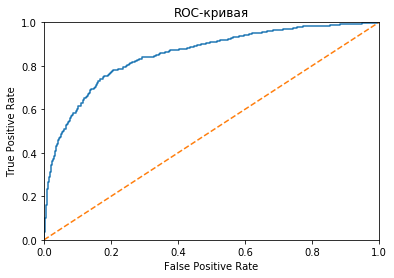

In [80]:
fpr, tpr, thresholds = roc_curve(target_test, model.predict_proba(feature_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle= '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Можно заметить, что оценка roc-auc-score показывает несколько более оптимистичную картину f1-score, это следует из ее построения и несбалансированности данных. Особенно это видно на первом этапе, когда модель обучалась на исходных данных, оценка на модели случайного леса достигла 0.79. То есть из-за большого количества истинно-отрицательных ответов доля ложноположительных ответов уменьшается, график смещается влево.

Итак, целью проекта было построить модель с предельно большим значением F1-меры. Итоговая оценка точности достигла 0.62. 
В ходе работы сравнивались различные методы для работы с дисбалансом классов. В данном проекте лучше всего себя показал метод увеличения выборки. На этапе предработки данных были устранены пропуски, категориальные данные преобразованы методом One-Hot-Encoding. В качестве моделей для обучения были выбраны логистическая регрессия и случайный лес. Последняя показала лучший результат с f1-мерой 0.62.
